In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pyarrow.parquet as pq
trips = pq.read_table("trips09.parquet") 
trips = trips.to_pandas()
import geopandas as gpd
geo = gpd.read_file("geo.shp")

In [2]:
df = trips[~((trips['DOLocationID'] == 265) | (trips['PULocationID'] == 265))]

In [3]:
df[df['DOLocationID'].isin([265]) | df['PULocationID'].isin([265])]

,request_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time


In [4]:
df['do_hour'] = df['dropoff_datetime'].dt.hour

C:\Users\r-cet\AppData\Local\Temp\ipykernel_16896\433317477.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['do_hour'] = df['dropoff_datetime'].dt.hour


In [5]:
c = df.groupby(['do_hour', 'DOLocationID']).size().reset_index(name='count')
# Compute percentage of total trips per group
c['proportion'] = c['count'] / c['count'].sum()

TOTAL_SAMPLES = round(len(df)*0.01)
# Calculate number of samples per group (proportional to original distribution)
c['sample_size'] = (c['proportion'] * TOTAL_SAMPLES).astype(int)
# Ensure minimum of 1 sample per group
c['sample_size'] = c['sample_size'].clip(lower=1)

def stratified_sampling(group):
    """Sample each group based on precomputed sample sizes"""
    n = c.loc[
        (c['do_hour'] == group.name[0]) & 
        (c['DOLocationID'] == group.name[1]), 
        'sample_size'
    ].values[0]
    return group.sample(n=min(n, len(group)), random_state=42)

# Apply sampling per (dropoff_hour, DOLocationID) group
sampled_df = df.groupby(['do_hour', 'DOLocationID'], group_keys=False).apply(stratified_sampling)

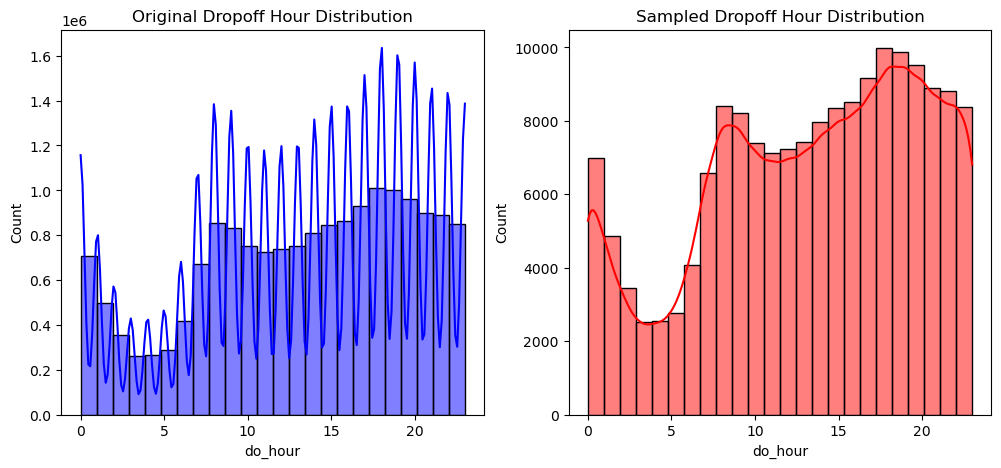

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(df['do_hour'], bins=24, kde=True, ax=axes[0], color='blue')
axes[0].set_title('Original Dropoff Hour Distribution')

sns.histplot(sampled_df['do_hour'], bins=24, kde=True, ax=axes[1], color='red')
axes[1].set_title('Sampled Dropoff Hour Distribution')
plt.savefig("Sampled Dropoff Hour Distribution.png", format='png', dpi=1200)
plt.show()

In [7]:
s = sampled_df
s.reset_index(drop=True, inplace=True)
s.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168954 entries, 0 to 168953
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   request_datetime  168954 non-null  datetime64[us]
 1   pickup_datetime   168954 non-null  datetime64[us]
 2   dropoff_datetime  168954 non-null  datetime64[us]
 3   PULocationID      168954 non-null  int32         
 4   DOLocationID      168954 non-null  int32         
 5   trip_miles        168954 non-null  float64       
 6   trip_time         168954 non-null  int64         
 7   do_hour           168954 non-null  int32         
dtypes: datetime64[us](3), float64(1), int32(3), int64(1)
memory usage: 8.4 MB


In [8]:
from shapely.geometry import Point
import random

s = s.merge(geo[['LocationID', 'geometry']], 
                             left_on='DOLocationID', 
                             right_on='LocationID', 
                             how='left')

def random_point_in_polygon(polygon):
    min_x, min_y, max_x, max_y = polygon.bounds
    while True:
        p = Point(np.random.uniform(min_x, max_x), np.random.uniform(min_y, max_y))
        if polygon.contains(p):
            return p

s['dropoff_point'] = s['geometry'].apply(lambda poly: random_point_in_polygon(poly) if poly else None)
s['dropoff_latitude'] = s['dropoff_point'].apply(lambda p: p.y if p else None)
s['dropoff_longitude'] = s['dropoff_point'].apply(lambda p: p.x if p else None)
s = gpd.GeoDataFrame(s, geometry='dropoff_point', crs="EPSG:4326")
s

,request_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,trip_time,do_hour,LocationID,geometry,dropoff_point,dropoff_latitude,dropoff_longitude
0,2024-09-08 23:37:45,2024-09-08 23:40:32,2024-09-09 00:14:13,230,1,16.710,2021,0,1,"POLYGON ((-74.18445 40.695, -74.18449 40.6951,...",POINT (-74.1806 40.6796),40.679599,-74.180603
1,2024-09-27 00:41:04,2024-09-27 00:43:09,2024-09-27 00:58:19,241,3,3.130,910,0,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.85536 40.87224),40.872239,-73.855356
2,2024-09-28 00:37:46,2024-09-28 00:39:14,2024-09-28 00:45:42,254,3,1.650,388,0,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.84268 40.8672),40.867198,-73.842681
3,2024-09-12 00:25:42,2024-09-12 00:29:25,2024-09-12 00:41:41,78,3,5.920,736,0,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.85177 40.86678),40.866778,-73.851772
4,2024-09-03 23:16:47,2024-09-03 23:29:54,2024-09-04 00:07:25,230,3,14.970,2251,0,3,"POLYGON ((-73.84793 40.87134, -73.84725 40.870...",POINT (-73.85197 40.86887),40.868870,-73.851967
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168949,2024-09-24 23:49:59,2024-09-24 23:53:45,2024-09-24 23:57:36,75,263,1.000,231,23,263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.95246 40.77925),40.779251,-73.952461
168950,2024-09-28 22:34:45,2024-09-28 22:57:43,2024-09-28 23:49:11,222,263,19.390,3088,23,263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.94917 40.78431),40.784310,-73.949171
168951,2024-09-19 23:17:04,2024-09-19 23:19:49,2024-09-19 23:23:36,262,263,0.610,227,23,263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.94802 40.77966),40.779657,-73.948019
168952,2024-09-11 22:44:21,2024-09-11 22:47:43,2024-09-11 23:10:56,213,263,7.760,1393,23,263,"POLYGON ((-73.95219 40.77302, -73.95269 40.772...",POINT (-73.95457 40.77568),40.775682,-73.954572


In [11]:
import hdbscan
coords = s[['dropoff_latitude', 'dropoff_longitude']].dropna().to_numpy()
# MST + Core-Distance MIT FIXEM min_samples vorberechnen
hdb = hdbscan.HDBSCAN(
    gen_min_span_tree=True,
    min_samples=4,  # Fester Wert
    metric='haversine'
).fit(np.radians(coords))

for min_cluster_size in [9, 12, 15]:
    hdb.min_cluster_size = min_cluster_size
    clusters = hdb.fit_predict(np.radians(coords))
    
    # Statistik pro Durchgang
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    noise_ratio = np.sum(clusters == -1) / len(clusters) * 100
    print(f"""
    min_cluster_size = {min_cluster_size}
    ----------------------------------
    Cluster gefunden: {len(unique_clusters) - 1}  # -1 wegen Noise-Label (-1)
    Rauschpunkte: {noise_ratio:.1f}%
    Größter Cluster: {counts[1:].max()} Punkte
    """)


    min_cluster_size = 9
    ----------------------------------
    Cluster gefunden: 4340  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 36.9%
    Größter Cluster: 4001 Punkte
    

    min_cluster_size = 12
    ----------------------------------
    Cluster gefunden: 1962  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 22.5%
    Größter Cluster: 61635 Punkte
    

    min_cluster_size = 15
    ----------------------------------
    Cluster gefunden: 1433  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 21.3%
    Größter Cluster: 61635 Punkte
    


In [12]:
for min_cluster_size in [18, 21, 24]:
    hdb.min_cluster_size = min_cluster_size
    clusters = hdb.fit_predict(np.radians(coords))
    
    # Statistik pro Durchgang
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    noise_ratio = np.sum(clusters == -1) / len(clusters) * 100
    print(f"""
    min_cluster_size = {min_cluster_size}
    ----------------------------------
    Cluster gefunden: {len(unique_clusters) - 1}  # -1 wegen Noise-Label (-1)
    Rauschpunkte: {noise_ratio:.1f}%
    Größter Cluster: {counts[1:].max()} Punkte
    """)


    min_cluster_size = 18
    ----------------------------------
    Cluster gefunden: 1146  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 20.7%
    Größter Cluster: 61635 Punkte
    

    min_cluster_size = 21
    ----------------------------------
    Cluster gefunden: 967  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 21.1%
    Größter Cluster: 61635 Punkte
    

    min_cluster_size = 24
    ----------------------------------
    Cluster gefunden: 849  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 21.5%
    Größter Cluster: 61635 Punkte
    


In [13]:
for min_cluster_size in [16, 17, 18]:
    hdb.min_cluster_size = min_cluster_size
    clusters = hdb.fit_predict(np.radians(coords))
    
    # Statistik pro Durchgang
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    noise_ratio = np.sum(clusters == -1) / len(clusters) * 100
    print(f"""
    min_cluster_size = {min_cluster_size}
    ----------------------------------
    Cluster gefunden: {len(unique_clusters) - 1}  # -1 wegen Noise-Label (-1)
    Rauschpunkte: {noise_ratio:.1f}%
    Größter Cluster: {counts[1:].max()} Punkte
    """)


    min_cluster_size = 16
    ----------------------------------
    Cluster gefunden: 1292  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 20.5%
    Größter Cluster: 61635 Punkte
    

    min_cluster_size = 17
    ----------------------------------
    Cluster gefunden: 1225  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 20.7%
    Größter Cluster: 61635 Punkte
    

    min_cluster_size = 18
    ----------------------------------
    Cluster gefunden: 1146  # -1 wegen Noise-Label (-1)
    Rauschpunkte: 20.7%
    Größter Cluster: 61635 Punkte
    


In [14]:
hdb.min_cluster_size = 24
s['cluster'] = hdb.fit_predict(np.radians(coords))
print(s['cluster'].value_counts())

cluster
 36     61635
-1      36241
 529     4143
 480     4132
 208     3635
        ...  
 139       24
 744       24
 588       24
 121       24
 89        24
Name: count, Length: 850, dtype: int64


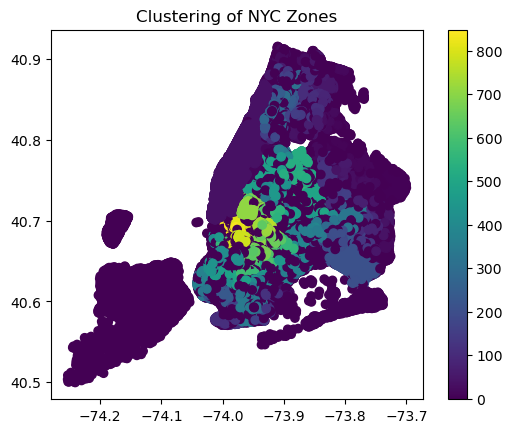

In [15]:
s.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

0.2073108656794157


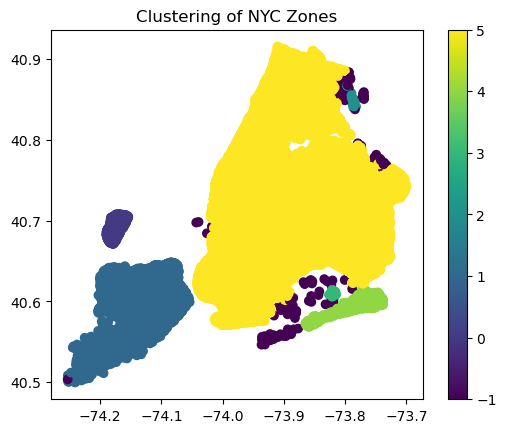

In [16]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=15,  # Testwert
    min_samples=15,       # Höher als min_cluster_size/2
    metric='haversine'
)
s['cluster'] = hdb.fit_predict(np.radians(coords))
print(np.sum(clusters == -1) / len(clusters))
s.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

0.2073108656794157


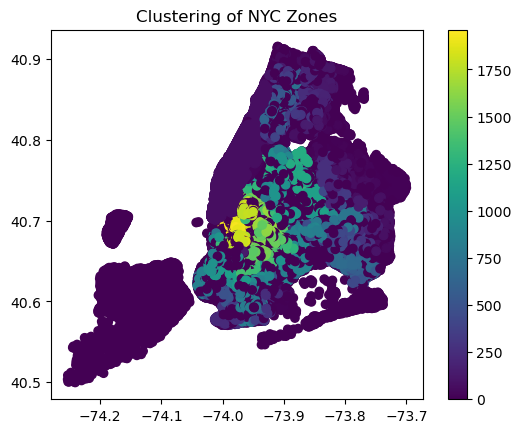

In [17]:
hdb = hdbscan.HDBSCAN(
    min_cluster_size=12,  # Testwert
    min_samples=4,       # Höher als min_cluster_size/2
    metric='haversine'
)
s['cluster'] = hdb.fit_predict(np.radians(coords))
print(np.sum(clusters == -1) / len(clusters))
s.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

In [18]:
best_noise_ratio = 1.0
best_params = {}

for min_cluster_size in [5, 8, 10, 12]:
    for min_samples in [2, 3, 5]:
        hdb = hdbscan.HDBSCAN(
            min_cluster_size=min_cluster_size,
            min_samples=min_samples,
            metric='haversine'
        )
        clusters = hdb.fit_predict(np.radians(coords))
        noise_ratio = np.sum(clusters == -1) / len(clusters)
        
        if 0.1 < noise_ratio < 0.3:  # Akzeptabler Rauschbereich
            best_params = {'min_cluster_size': min_cluster_size, 'min_samples': min_samples}
            break  # Early Stopping

In [19]:
best_params

{'min_cluster_size': 12, 'min_samples': 2}

In [20]:
hdb = hdbscan.HDBSCAN(min_samples=2, min_cluster_size=12, metric='haversine')
s['cluster'] = hdb.fit_predict(np.radians(coords))
print(s['cluster'].value_counts())

cluster
-1       42690
 2320     4004
 1        2392
 0        1265
 5         641
         ...  
 3084       12
 2462       12
 1411       12
 3596       12
 4381       12
Name: count, Length: 4458, dtype: int64


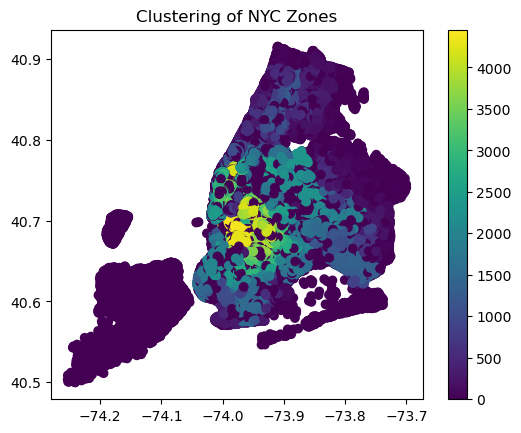

In [22]:
s.plot(column='cluster', cmap='viridis', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

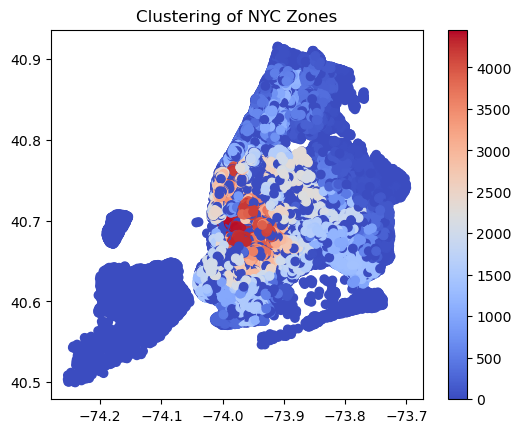

In [23]:
s.plot(column='cluster', cmap='coolwarm', legend=True)
plt.title("Clustering of NYC Zones")
plt.show()

**Results**

In [29]:
from sklearn.utils import resample

# Zufällige 10% Stichprobe für schnelle Iteration
coords_sample = resample(coords, n_samples=int(0.1 * len(coords)), random_state=42)

# Parameter-Raster für min_samples testen
best_min_samples = None
best_noise_ratio = 1.0

for min_samples in [2,3,4,5,6,7]:
    hdb = hdbscan.HDBSCAN(
        min_cluster_size=15,  # Startwert (später angepasst)
        min_samples=min_samples,
        metric='haversine'
    )
    clusters = hdb.fit_predict(np.radians(coords_sample))
    noise_ratio = np.sum(clusters == -1) / len(clusters)
    
    if noise_ratio < best_noise_ratio:
        best_min_samples = min_samples
        best_noise_ratio = noise_ratio

print(f"Optimales min_samples: {best_min_samples} (Noise: {best_noise_ratio:.1%})")

Optimales min_samples: 5 (Noise: 0.2%)


In [30]:
# MST und Core-Distance MIT FIXEM min_samples vorberechnen
hdb = hdbscan.HDBSCAN(
    gen_min_span_tree=True,       # MST wird gespeichert
    min_samples=best_min_samples, # Aus Stufe 1
    metric='haversine'
).fit(np.radians(coords))         # Auf VOLLEN Daten

# Jetzt min_cluster_size variieren (MST wiederverwenden)
results = []
for min_cluster_size in [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]:
    hdb.min_cluster_size = min_cluster_size  # Nur Cluster-Größe ändern
    clusters = hdb.fit_predict(np.radians(coords))  # MST wird NICHT neu berechnet
    
    # Metriken sammeln
    noise_ratio = np.sum(clusters == -1) / len(clusters)
    n_clusters = len(np.unique(clusters)) - 1  # Ignoriere Rauschen (-1)
    results.append((min_cluster_size, noise_ratio, n_clusters))

# Ergebnisse vergleichen
df_results = pd.DataFrame(results, columns=['min_cluster_size', 'noise_ratio', 'n_clusters'])
print(df_results.sort_values('noise_ratio'))

    min_cluster_size  noise_ratio  n_clusters
19                24     0.238450         745
12                17     0.239314        1107
13                18     0.240136        1051
14                19     0.241249         997
17                22     0.241782         855
15                20     0.241989         940
16                21     0.243137         901
18                23     0.243723         807
9                 14     0.248204        1417
10                15     0.248547        1332
11                16     0.249825        1243
5                 10     0.254004        2088
6                 11     0.257147        1915
7                 12     0.257987        1747
8                 13     0.258698        1618
3                  8     0.413426        4295
2                  7     0.416119        4859
4                  9     0.416368        3820
1                  6     0.432940        5741
0                  5     0.436444        6461



Exponentielle Anpassung der Clusteranzahl:
Angepasste Parameter: a = 14208.45, b = -0.1573
R^2 = 0.96


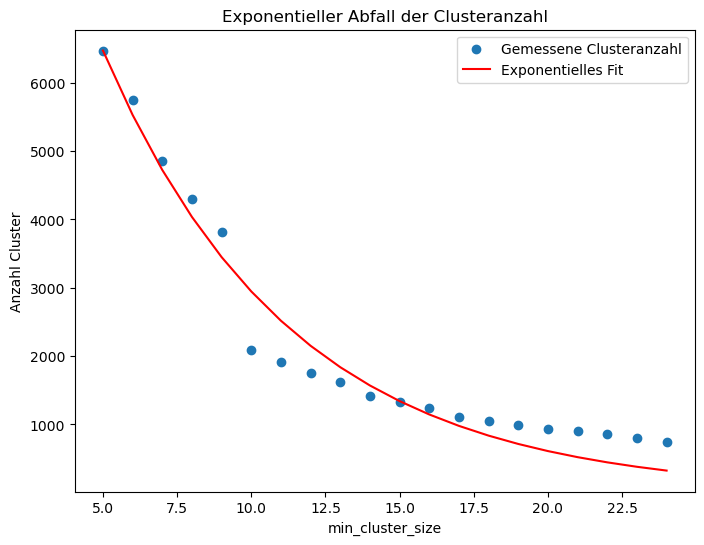

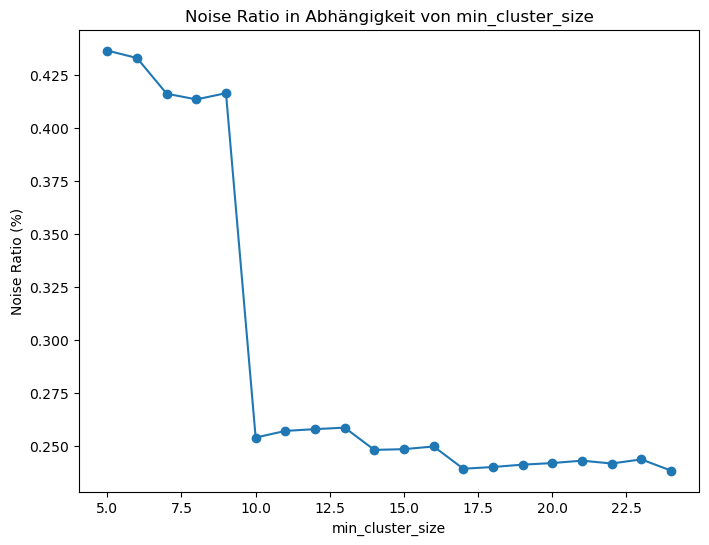

In [32]:
# Exponentielle Regression zur Modellierung des Abfalls der Clusteranzahl
# min_cluster_size: x-Werte und n_clusters: y-Werte
from scipy.optimize import curve_fit

x_data = df_results['min_cluster_size'].values
y_data = df_results['n_clusters'].values

# exponentielle Modell: y = a * exp(b * x)
def exp_model(x, a, b):
    return a * np.exp(b * x)

# Kurvenanpassung durch p0 schätzt anfangs a als ersten y-Wert, b als -0.1 (negativ, weil abnehmend)
params, covariance = curve_fit(exp_model, x_data, y_data, p0=(y_data[0], -0.1))
a_fit, b_fit = params

# Vorhrsagen
y_pred = exp_model(x_data, a_fit, b_fit)

# R^2
ss_res = np.sum((y_data - y_pred) ** 2)
ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"\nExponentielle Anpassung der Clusteranzahl:")
print(f"Angepasste Parameter: a = {a_fit:.2f}, b = {b_fit:.4f}")
print(f"R^2 = {r_squared:.2f}")

# Clusteranzahl vs. min_cluster_size mit exponentiellem Fit
plt.figure(figsize=(8, 6))
plt.scatter(x_data, y_data, label='Gemessene Clusteranzahl')
plt.plot(x_data, y_pred, color='red', label='Exponentielles Fit')
plt.xlabel('min_cluster_size')
plt.ylabel('Anzahl Cluster')
plt.title('Exponentieller Abfall der Clusteranzahl')
plt.legend()
plt.show()

# Noise-Verhältnisses
plt.figure(figsize=(8, 6))
plt.plot(df_results['min_cluster_size'], df_results['noise_ratio'], marker='o')
plt.xlabel('min_cluster_size')
plt.ylabel('Noise Ratio (%)')
plt.title('Noise Ratio in Abhängigkeit von min_cluster_size')
plt.show()

In [33]:
np.bincount(clusters[clusters != -1])

array([ 1265,    25,    24,  2338,    95,   318,   212,   170,    27,
          38,    28,    27,   181,    80,    29,   141,    28,    32,
          29,    49,    68,    39,    65,    36,    32,   115,    34,
          24,    25,    65,    51,    58,    51,    30,   115,    42,
         149,    42,   196,    53,    29, 61686,    27,    97,    53,
          62,    91,   101,    25,    70,   178,    54,    40,    41,
          42,    64,    77,    50,    25,    35,    75,    43,    30,
          75,    39,    46,    67,    30,    27,    35,    52,    29,
          45,    36,    54,    48,    96,    25,    83,   110,    80,
          30,    40,    25,    32,    29,    43,    61,    60,    48,
          74,   148,    43,    61,    66,    43,    26,    51,    37,
          37,    37,    30,    78,   112,    50,    34,    47,    34,
          30,    51,    68,    96,    54,    45,   826,   126,    81,
          78,    29,    59,    26,   100,    33,    31,    28,    27,
          36,   122,

**Other reults than in thesis but similar, because i runned it again**

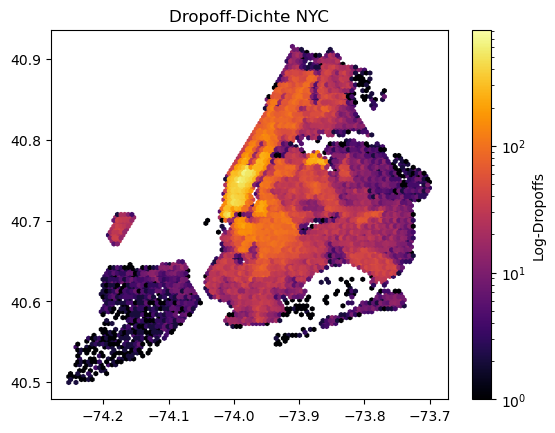

In [27]:
plt.hexbin(coords[:,1], coords[:,0], gridsize=100, cmap='inferno', bins='log')
plt.colorbar(label='Log-Dropoffs')
plt.title("Dropoff-Dichte NYC")
plt.show()